Kutibxonalar

In [1]:
import os
import time
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# GPU ni tekshirish
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
    print(f"GPU mavjud: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")  # CPU
    print("GPU mavjud emas, CPU ishlatiladi.")

torch.cuda.empty_cache()  # Xotiradan bo'shatish
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

GPU mavjud: NVIDIA GeForce RTX 3060
cuda


In [24]:
# Ma'lumotlar to'plamini yuklash va transformatsiyalar
data_dir = 'face_emoc_ds'
batch_size = 32  # Batch size ni oshirish
image_size = 224

# Data augmentation va transformatsiyalar
transform = transforms.Compose([
    transforms.Lambda(lambda img: img if img.mode == 'RGB' else img.convert('RGB')),
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(), # Tensorga o'zgartirish
    transforms.RandomErasing(p=0.7, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=(0, 0, 0)),  # O'chiqlik bloklarini qo'shish
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_names = dataset.classes
print("Class names:", class_names)

Class names: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [25]:
# Modelni yuklash va sozlash
def load_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout qo'shildi
            nn.Linear(model.fc.in_features, num_classes)
        )
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout qo'shildi
            nn.Linear(model.classifier.in_features, num_classes)
        )
    elif model_name == 'vgg19':
        model = models.vgg19(pretrained=True)
        model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),  # Dropout qo'shildi
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),  # Dropout qo'shildi
            nn.Linear(4096, num_classes)
        )
    else:
        raise ValueError("Model name not recognized. Choose from 'resnet50', 'densenet121', 'vgg19'.")
    
    # Butun modelni fine-tune qilish
    for param in model.parameters():
        param.requires_grad = True
    
    return model.to(device)

#model_name = 'densenet121'  # Modelni tanlang: 'resnet50', 'densenet121', 'vgg19'
#model_name = 'resnet50'  # Modelni tanlang: 'resnet50', 'densenet121', 'vgg19'  Ikkinchi training
model_name = 'vgg19'  # Modelni tanlang: 'resnet50', 'densenet121', 'vgg19'  
model = load_model(model_name, len(class_names))


In [26]:
# Loss va optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Learning rate ni oshirish
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


In [27]:
# Trening va validatsiya funksiyasi
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    # Natijalarni saqlash uchun fayl ochamiz
    with open("training_results.txt", "w") as f:
        f.write("Epoch, Train Loss, Train Accuracy, Val Loss, Val Accuracy, Time (sec)\n")

    for epoch in range(num_epochs):
        start_time = time.time()

        # O'quv rejimi
        model.train()
        train_loss, train_correct = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * train_correct.double() / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validatsiya rejimi
        model.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * val_correct.double() / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%, '
              f'Time: {epoch_time:.2f} sec')

        # Natijalarni faylga yozamiz
        with open("training_results.txt", "a") as f:
            f.write(f"{epoch+1}, {epoch_train_loss:.4f}, {epoch_train_acc:.2f}, "
                    f"{epoch_val_loss:.4f}, {epoch_val_acc:.2f}, {epoch_time:.2f}\n")

        # Learning rate ni sozlash
        scheduler.step(epoch_val_loss)

        # Modelni saqlash
        torch.save(model.state_dict(), f'{model_name}_epoch_{epoch+1}.pth')

    return train_losses, train_accuracies, val_losses, val_accuracies, epoch_times


# Trainingni boshlash VGGNet19

In [28]:
# Treningni boshlash VGG Net
num_epochs = 30
train_losses, train_accuracies, val_losses, val_accuracies, epoch_times = train_and_validate(
    model, criterion, optimizer, train_loader, val_loader, num_epochs
)

Validation: 100%|██████████| 453/453 [07:25<00:00,  1.02it/s]


Epoch 1/30, Train Loss: 1.2941, Train Accuracy: 51.33%, Val Loss: 1.0546, Val Accuracy: 60.98%, Time: 2896.72 sec


Validation: 100%|██████████| 453/453 [02:57<00:00,  2.55it/s]


Epoch 2/30, Train Loss: 1.0195, Train Accuracy: 62.30%, Val Loss: 1.0103, Val Accuracy: 62.77%, Time: 1782.35 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.59it/s]


Epoch 3/30, Train Loss: 0.9349, Train Accuracy: 65.48%, Val Loss: 0.9403, Val Accuracy: 65.37%, Time: 1287.31 sec


Validation: 100%|██████████| 453/453 [02:07<00:00,  3.56it/s]


Epoch 4/30, Train Loss: 0.8819, Train Accuracy: 67.59%, Val Loss: 0.8798, Val Accuracy: 67.43%, Time: 1191.04 sec


Validation: 100%|██████████| 453/453 [02:07<00:00,  3.55it/s]


Epoch 5/30, Train Loss: 0.8527, Train Accuracy: 68.65%, Val Loss: 0.8624, Val Accuracy: 68.70%, Time: 1192.70 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.59it/s]


Epoch 6/30, Train Loss: 0.8141, Train Accuracy: 70.12%, Val Loss: 0.8755, Val Accuracy: 67.94%, Time: 1190.50 sec


Validation: 100%|██████████| 453/453 [05:29<00:00,  1.38it/s]


Epoch 7/30, Train Loss: 0.7927, Train Accuracy: 70.69%, Val Loss: 0.8522, Val Accuracy: 68.95%, Time: 1664.91 sec


Validation: 100%|██████████| 453/453 [05:08<00:00,  1.47it/s]


Epoch 8/30, Train Loss: 0.7667, Train Accuracy: 71.54%, Val Loss: 0.8383, Val Accuracy: 68.84%, Time: 2208.56 sec


Validation: 100%|██████████| 453/453 [03:17<00:00,  2.29it/s]


Epoch 9/30, Train Loss: 0.7501, Train Accuracy: 72.30%, Val Loss: 0.8500, Val Accuracy: 69.58%, Time: 1561.19 sec


Validation: 100%|██████████| 453/453 [03:12<00:00,  2.36it/s]


Epoch 10/30, Train Loss: 0.7252, Train Accuracy: 73.17%, Val Loss: 0.7858, Val Accuracy: 71.44%, Time: 1527.66 sec


Validation: 100%|██████████| 453/453 [03:18<00:00,  2.28it/s]


Epoch 11/30, Train Loss: 0.7080, Train Accuracy: 73.89%, Val Loss: 0.7899, Val Accuracy: 70.65%, Time: 1418.86 sec


Validation: 100%|██████████| 453/453 [03:20<00:00,  2.26it/s]


Epoch 12/30, Train Loss: 0.6921, Train Accuracy: 74.31%, Val Loss: 0.7859, Val Accuracy: 71.53%, Time: 1555.45 sec


Validation: 100%|██████████| 453/453 [03:11<00:00,  2.37it/s]


Epoch 13/30, Train Loss: 0.6754, Train Accuracy: 75.30%, Val Loss: 0.7926, Val Accuracy: 71.28%, Time: 1555.51 sec


Validation: 100%|██████████| 453/453 [02:54<00:00,  2.59it/s]


Epoch 14/30, Train Loss: 0.6604, Train Accuracy: 75.59%, Val Loss: 0.7874, Val Accuracy: 71.96%, Time: 1534.25 sec


Validation: 100%|██████████| 453/453 [02:07<00:00,  3.55it/s]


Epoch 15/30, Train Loss: 0.6481, Train Accuracy: 76.07%, Val Loss: 0.7849, Val Accuracy: 71.99%, Time: 1195.19 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.58it/s]


Epoch 16/30, Train Loss: 0.6298, Train Accuracy: 76.83%, Val Loss: 0.7912, Val Accuracy: 72.46%, Time: 1189.15 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.57it/s]


Epoch 17/30, Train Loss: 0.6211, Train Accuracy: 77.25%, Val Loss: 0.7793, Val Accuracy: 72.45%, Time: 1188.99 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.57it/s]


Epoch 18/30, Train Loss: 0.6096, Train Accuracy: 77.57%, Val Loss: 0.7695, Val Accuracy: 71.86%, Time: 1190.68 sec


Validation: 100%|██████████| 453/453 [02:07<00:00,  3.55it/s]


Epoch 19/30, Train Loss: 0.5933, Train Accuracy: 78.28%, Val Loss: 0.8021, Val Accuracy: 71.84%, Time: 1189.94 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.59it/s]


Epoch 20/30, Train Loss: 0.5833, Train Accuracy: 78.51%, Val Loss: 0.7830, Val Accuracy: 72.09%, Time: 1186.18 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.59it/s]


Epoch 21/30, Train Loss: 0.5732, Train Accuracy: 78.96%, Val Loss: 0.7599, Val Accuracy: 73.24%, Time: 1189.24 sec


Validation: 100%|██████████| 453/453 [02:05<00:00,  3.60it/s]


Epoch 22/30, Train Loss: 0.5648, Train Accuracy: 79.12%, Val Loss: 0.8046, Val Accuracy: 73.07%, Time: 1188.21 sec


Validation: 100%|██████████| 453/453 [02:07<00:00,  3.56it/s]


Epoch 23/30, Train Loss: 0.5491, Train Accuracy: 79.91%, Val Loss: 0.8212, Val Accuracy: 72.24%, Time: 1189.90 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.59it/s]


Epoch 24/30, Train Loss: 0.5461, Train Accuracy: 79.87%, Val Loss: 0.7849, Val Accuracy: 72.31%, Time: 1190.36 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.57it/s]


Epoch 25/30, Train Loss: 0.5336, Train Accuracy: 80.55%, Val Loss: 0.7903, Val Accuracy: 72.78%, Time: 1190.52 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.58it/s]


Epoch 26/30, Train Loss: 0.5219, Train Accuracy: 80.72%, Val Loss: 0.7752, Val Accuracy: 73.01%, Time: 1189.31 sec


Validation: 100%|██████████| 453/453 [02:07<00:00,  3.55it/s]


Epoch 27/30, Train Loss: 0.5164, Train Accuracy: 81.22%, Val Loss: 0.7896, Val Accuracy: 72.93%, Time: 1190.65 sec


Validation: 100%|██████████| 453/453 [02:07<00:00,  3.55it/s]


Epoch 28/30, Train Loss: 0.4175, Train Accuracy: 84.64%, Val Loss: 0.7686, Val Accuracy: 74.56%, Time: 1191.31 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.58it/s]


Epoch 29/30, Train Loss: 0.3752, Train Accuracy: 86.20%, Val Loss: 0.7805, Val Accuracy: 74.61%, Time: 1189.65 sec


Validation: 100%|██████████| 453/453 [02:06<00:00,  3.57it/s]


Epoch 30/30, Train Loss: 0.3618, Train Accuracy: 86.67%, Val Loss: 0.8027, Val Accuracy: 74.50%, Time: 1189.08 sec


# Treningni boshlash Resnet

In [9]:
# Treningni boshlash Resnet
num_epochs = 30
train_losses, train_accuracies, val_losses, val_accuracies, epoch_times = train_and_validate(
    model, criterion, optimizer, train_loader, val_loader, num_epochs
)

Validation: 100%|██████████| 906/906 [07:18<00:00,  2.07it/s]


Epoch 1/30, Train Loss: 1.2162, Train Accuracy: 54.99%, Val Loss: 0.9787, Val Accuracy: 64.23%, Time: 2585.65 sec


Validation: 100%|██████████| 906/906 [03:12<00:00,  4.71it/s]


Epoch 2/30, Train Loss: 1.0093, Train Accuracy: 62.83%, Val Loss: 0.8974, Val Accuracy: 66.42%, Time: 1630.34 sec


Validation: 100%|██████████| 906/906 [03:12<00:00,  4.71it/s]


Epoch 3/30, Train Loss: 0.9356, Train Accuracy: 65.76%, Val Loss: 0.8761, Val Accuracy: 67.85%, Time: 1590.62 sec


Validation: 100%|██████████| 906/906 [03:22<00:00,  4.48it/s]


Epoch 4/30, Train Loss: 0.8840, Train Accuracy: 67.43%, Val Loss: 0.8270, Val Accuracy: 69.71%, Time: 1599.77 sec


Validation: 100%|██████████| 906/906 [03:40<00:00,  4.10it/s]


Epoch 5/30, Train Loss: 0.8477, Train Accuracy: 68.78%, Val Loss: 0.8624, Val Accuracy: 67.96%, Time: 1775.70 sec


Validation: 100%|██████████| 906/906 [03:12<00:00,  4.70it/s]


Epoch 6/30, Train Loss: 0.8178, Train Accuracy: 69.95%, Val Loss: 0.8058, Val Accuracy: 70.52%, Time: 1592.06 sec


Validation: 100%|██████████| 906/906 [03:13<00:00,  4.67it/s]


Epoch 7/30, Train Loss: 0.7933, Train Accuracy: 70.57%, Val Loss: 0.7863, Val Accuracy: 71.04%, Time: 1591.45 sec


Validation: 100%|██████████| 906/906 [03:12<00:00,  4.69it/s]


Epoch 8/30, Train Loss: 0.7726, Train Accuracy: 71.56%, Val Loss: 0.7641, Val Accuracy: 71.55%, Time: 1592.65 sec


Validation: 100%|██████████| 906/906 [03:12<00:00,  4.71it/s]


Epoch 9/30, Train Loss: 0.7547, Train Accuracy: 72.37%, Val Loss: 0.7689, Val Accuracy: 71.68%, Time: 1592.40 sec


Validation: 100%|██████████| 906/906 [03:13<00:00,  4.69it/s]


Epoch 10/30, Train Loss: 0.7350, Train Accuracy: 72.92%, Val Loss: 0.7660, Val Accuracy: 71.36%, Time: 1592.24 sec


Validation: 100%|██████████| 906/906 [02:20<00:00,  6.47it/s]


Epoch 11/30, Train Loss: 0.7190, Train Accuracy: 73.49%, Val Loss: 0.7640, Val Accuracy: 71.90%, Time: 963.08 sec


Validation: 100%|██████████| 906/906 [01:45<00:00,  8.61it/s]


Epoch 12/30, Train Loss: 0.7045, Train Accuracy: 74.00%, Val Loss: 0.7630, Val Accuracy: 72.11%, Time: 1454.44 sec


Validation: 100%|██████████| 906/906 [03:13<00:00,  4.69it/s]


Epoch 13/30, Train Loss: 0.6903, Train Accuracy: 74.62%, Val Loss: 0.7381, Val Accuracy: 72.59%, Time: 1422.60 sec


Validation: 100%|██████████| 906/906 [03:12<00:00,  4.70it/s]


Epoch 14/30, Train Loss: 0.6751, Train Accuracy: 75.37%, Val Loss: 0.7521, Val Accuracy: 72.26%, Time: 1589.38 sec


Validation: 100%|██████████| 906/906 [03:13<00:00,  4.69it/s]


Epoch 15/30, Train Loss: 0.6620, Train Accuracy: 75.56%, Val Loss: 0.7532, Val Accuracy: 72.39%, Time: 1589.75 sec


Validation: 100%|██████████| 906/906 [03:13<00:00,  4.69it/s]


Epoch 16/30, Train Loss: 0.6488, Train Accuracy: 75.95%, Val Loss: 0.7346, Val Accuracy: 73.15%, Time: 1590.72 sec


Validation: 100%|██████████| 906/906 [03:11<00:00,  4.72it/s]


Epoch 17/30, Train Loss: 0.6371, Train Accuracy: 76.45%, Val Loss: 0.7342, Val Accuracy: 72.86%, Time: 1589.66 sec


Validation: 100%|██████████| 906/906 [01:44<00:00,  8.64it/s]


Epoch 18/30, Train Loss: 0.6196, Train Accuracy: 77.09%, Val Loss: 0.7338, Val Accuracy: 73.41%, Time: 1502.83 sec


Validation: 100%|██████████| 906/906 [02:32<00:00,  5.93it/s]


Epoch 19/30, Train Loss: 0.6094, Train Accuracy: 77.56%, Val Loss: 0.7287, Val Accuracy: 73.03%, Time: 1070.28 sec


Validation: 100%|██████████| 906/906 [02:42<00:00,  5.59it/s]


Epoch 20/30, Train Loss: 0.6009, Train Accuracy: 77.80%, Val Loss: 0.7413, Val Accuracy: 73.73%, Time: 1081.18 sec


Validation: 100%|██████████| 906/906 [03:22<00:00,  4.48it/s]


Epoch 21/30, Train Loss: 0.5890, Train Accuracy: 78.31%, Val Loss: 0.7483, Val Accuracy: 73.42%, Time: 1183.33 sec


Validation: 100%|██████████| 906/906 [01:59<00:00,  7.59it/s]


Epoch 22/30, Train Loss: 0.5795, Train Accuracy: 78.62%, Val Loss: 0.7324, Val Accuracy: 73.67%, Time: 1111.90 sec


Validation: 100%|██████████| 906/906 [03:12<00:00,  4.70it/s]


Epoch 23/30, Train Loss: 0.5615, Train Accuracy: 79.25%, Val Loss: 0.7126, Val Accuracy: 74.20%, Time: 1507.94 sec


Validation: 100%|██████████| 906/906 [03:12<00:00,  4.71it/s]


Epoch 24/30, Train Loss: 0.5530, Train Accuracy: 79.68%, Val Loss: 0.7785, Val Accuracy: 72.49%, Time: 1588.60 sec


Validation: 100%|██████████| 906/906 [01:45<00:00,  8.61it/s]


Epoch 25/30, Train Loss: 0.5458, Train Accuracy: 79.88%, Val Loss: 0.7314, Val Accuracy: 73.97%, Time: 1426.50 sec


Validation: 100%|██████████| 906/906 [03:15<00:00,  4.63it/s]


Epoch 26/30, Train Loss: 0.5362, Train Accuracy: 80.06%, Val Loss: 0.7435, Val Accuracy: 73.40%, Time: 1183.52 sec


Validation: 100%|██████████| 906/906 [03:15<00:00,  4.64it/s]


Epoch 27/30, Train Loss: 0.5261, Train Accuracy: 80.65%, Val Loss: 0.7398, Val Accuracy: 73.87%, Time: 1604.22 sec


Validation: 100%|██████████| 906/906 [02:43<00:00,  5.55it/s]


Epoch 28/30, Train Loss: 0.5184, Train Accuracy: 81.06%, Val Loss: 0.7448, Val Accuracy: 73.89%, Time: 1401.32 sec


Validation: 100%|██████████| 906/906 [04:37<00:00,  3.27it/s]


Epoch 29/30, Train Loss: 0.5091, Train Accuracy: 81.24%, Val Loss: 0.7519, Val Accuracy: 74.22%, Time: 1211.81 sec


Validation: 100%|██████████| 906/906 [01:44<00:00,  8.63it/s]

Epoch 30/30, Train Loss: 0.4147, Train Accuracy: 84.74%, Val Loss: 0.7135, Val Accuracy: 75.92%, Time: 896.03 sec


# Treningni boshlash DenseNet121

In [16]:
# Treningni boshlash DenseNet121
num_epochs = 30
train_losses, train_accuracies, val_losses, val_accuracies, epoch_times = train_and_validate(
    model, criterion, optimizer, train_loader, val_loader, num_epochs
)

Validation: 100%|██████████| 453/453 [06:44<00:00,  1.12it/s]


Epoch 1/30, Train Loss: 1.2021, Train Accuracy: 55.37%, Val Loss: 0.9484, Val Accuracy: 65.23%, Time: 2141.73 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.59it/s]


Epoch 2/30, Train Loss: 0.9415, Train Accuracy: 65.25%, Val Loss: 0.8502, Val Accuracy: 68.23%, Time: 825.64 sec


Validation: 100%|██████████| 453/453 [02:51<00:00,  2.64it/s]


Epoch 3/30, Train Loss: 0.8700, Train Accuracy: 67.99%, Val Loss: 0.8301, Val Accuracy: 69.15%, Time: 1006.69 sec


Validation: 100%|██████████| 453/453 [01:39<00:00,  4.56it/s]


Epoch 4/30, Train Loss: 0.8209, Train Accuracy: 69.90%, Val Loss: 0.7937, Val Accuracy: 70.87%, Time: 906.55 sec


Validation: 100%|██████████| 453/453 [01:42<00:00,  4.43it/s]


Epoch 5/30, Train Loss: 0.7808, Train Accuracy: 71.30%, Val Loss: 0.7798, Val Accuracy: 71.19%, Time: 734.91 sec


Validation: 100%|██████████| 453/453 [02:51<00:00,  2.63it/s]


Epoch 6/30, Train Loss: 0.7507, Train Accuracy: 72.42%, Val Loss: 0.7588, Val Accuracy: 72.01%, Time: 949.47 sec


Validation: 100%|██████████| 453/453 [02:56<00:00,  2.56it/s]


Epoch 7/30, Train Loss: 0.7311, Train Accuracy: 73.05%, Val Loss: 0.7443, Val Accuracy: 72.91%, Time: 1008.22 sec


Validation: 100%|██████████| 453/453 [02:56<00:00,  2.57it/s]


Epoch 8/30, Train Loss: 0.7020, Train Accuracy: 74.34%, Val Loss: 0.7383, Val Accuracy: 72.78%, Time: 1103.42 sec


Validation: 100%|██████████| 453/453 [02:59<00:00,  2.53it/s]


Epoch 9/30, Train Loss: 0.6802, Train Accuracy: 75.06%, Val Loss: 0.7291, Val Accuracy: 73.10%, Time: 1131.69 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.58it/s]


Epoch 10/30, Train Loss: 0.6584, Train Accuracy: 75.84%, Val Loss: 0.7177, Val Accuracy: 73.86%, Time: 966.56 sec


Validation: 100%|██████████| 453/453 [02:54<00:00,  2.60it/s]


Epoch 11/30, Train Loss: 0.6482, Train Accuracy: 76.26%, Val Loss: 0.7302, Val Accuracy: 73.49%, Time: 952.75 sec


Validation: 100%|██████████| 453/453 [02:57<00:00,  2.55it/s]


Epoch 12/30, Train Loss: 0.6205, Train Accuracy: 77.06%, Val Loss: 0.7143, Val Accuracy: 73.98%, Time: 1081.95 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.59it/s]


Epoch 13/30, Train Loss: 0.6073, Train Accuracy: 77.54%, Val Loss: 0.7251, Val Accuracy: 73.96%, Time: 808.16 sec


Validation: 100%|██████████| 453/453 [02:56<00:00,  2.56it/s]


Epoch 14/30, Train Loss: 0.5849, Train Accuracy: 78.48%, Val Loss: 0.7158, Val Accuracy: 74.26%, Time: 916.51 sec


Validation: 100%|██████████| 453/453 [01:40<00:00,  4.51it/s]


Epoch 15/30, Train Loss: 0.5750, Train Accuracy: 78.89%, Val Loss: 0.7307, Val Accuracy: 73.94%, Time: 766.36 sec


Validation: 100%|██████████| 453/453 [02:51<00:00,  2.65it/s]


Epoch 16/30, Train Loss: 0.5553, Train Accuracy: 79.71%, Val Loss: 0.7328, Val Accuracy: 74.14%, Time: 1054.06 sec


Validation: 100%|██████████| 453/453 [02:56<00:00,  2.57it/s]


Epoch 17/30, Train Loss: 0.5377, Train Accuracy: 80.33%, Val Loss: 0.7397, Val Accuracy: 74.30%, Time: 1091.73 sec


Validation: 100%|██████████| 453/453 [02:57<00:00,  2.55it/s]


Epoch 18/30, Train Loss: 0.5268, Train Accuracy: 80.61%, Val Loss: 0.7429, Val Accuracy: 74.60%, Time: 895.45 sec


Validation: 100%|██████████| 453/453 [01:57<00:00,  3.84it/s]


Epoch 19/30, Train Loss: 0.4342, Train Accuracy: 83.97%, Val Loss: 0.7063, Val Accuracy: 75.47%, Time: 1045.73 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.60it/s]


Epoch 20/30, Train Loss: 0.4004, Train Accuracy: 85.32%, Val Loss: 0.7105, Val Accuracy: 76.16%, Time: 741.04 sec


Validation: 100%|██████████| 453/453 [01:37<00:00,  4.62it/s]


Epoch 21/30, Train Loss: 0.3840, Train Accuracy: 85.84%, Val Loss: 0.7300, Val Accuracy: 75.62%, Time: 707.31 sec


Validation: 100%|██████████| 453/453 [01:39<00:00,  4.56it/s]


Epoch 22/30, Train Loss: 0.3729, Train Accuracy: 86.37%, Val Loss: 0.7092, Val Accuracy: 76.69%, Time: 708.43 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.61it/s]


Epoch 23/30, Train Loss: 0.3646, Train Accuracy: 86.65%, Val Loss: 0.7333, Val Accuracy: 76.17%, Time: 707.09 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.61it/s]


Epoch 24/30, Train Loss: 0.3548, Train Accuracy: 86.99%, Val Loss: 0.7262, Val Accuracy: 76.07%, Time: 707.72 sec


Validation: 100%|██████████| 453/453 [01:37<00:00,  4.63it/s]


Epoch 25/30, Train Loss: 0.3455, Train Accuracy: 87.35%, Val Loss: 0.7388, Val Accuracy: 76.17%, Time: 725.38 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.60it/s]


Epoch 26/30, Train Loss: 0.3337, Train Accuracy: 87.80%, Val Loss: 0.7453, Val Accuracy: 76.01%, Time: 708.52 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.62it/s]


Epoch 27/30, Train Loss: 0.3311, Train Accuracy: 87.85%, Val Loss: 0.7289, Val Accuracy: 76.39%, Time: 706.91 sec


Validation: 100%|██████████| 453/453 [01:38<00:00,  4.60it/s]


Epoch 28/30, Train Loss: 0.3282, Train Accuracy: 87.88%, Val Loss: 0.7398, Val Accuracy: 76.56%, Time: 726.03 sec


Validation: 100%|██████████| 453/453 [01:40<00:00,  4.50it/s]


Epoch 29/30, Train Loss: 0.3227, Train Accuracy: 88.08%, Val Loss: 0.7334, Val Accuracy: 76.35%, Time: 709.91 sec


Validation: 100%|██████████| 453/453 [02:34<00:00,  2.93it/s]

Epoch 30/30, Train Loss: 0.3275, Train Accuracy: 87.89%, Val Loss: 0.7477, Val Accuracy: 76.10%, Time: 971.66 sec


# Visualization VGG Net

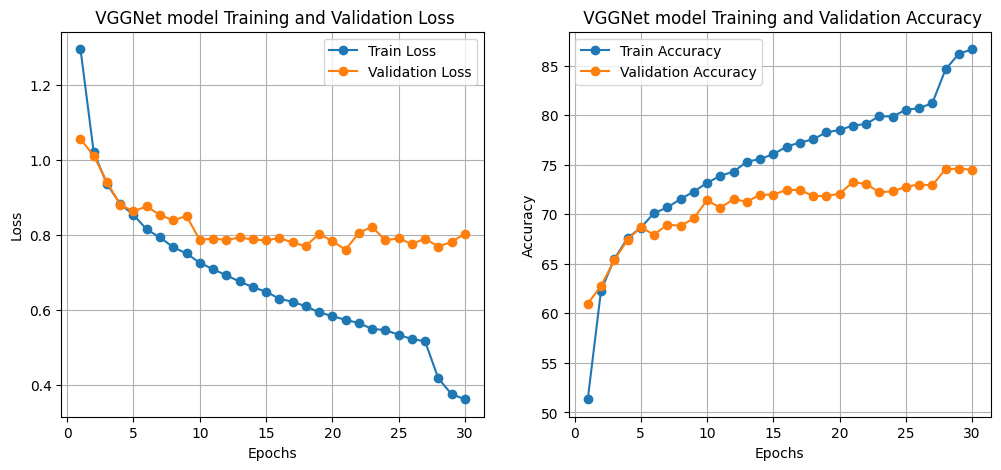

In [2]:
def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(' VGGNet model Training and Validation Loss')
    plt.legend()
    plt.grid()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(' VGGNet model Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    
    plt.show()

# Misol uchun tarix
history = {
    'train_loss': [1.2941, 1.0195, 0.9349, 0.8819, 0.8527, 0.8141, 0.7927, 0.7667, 0.7501, 0.7252, 0.7080, 0.6921, 0.6754, 0.6604, 0.6481, 0.6298, 0.6211, 0.6096, 0.5933, 0.5833, 0.5732, 0.5648, 0.5491, 0.5461, 0.5336, 0.5219, 0.5164, 0.4175, 0.3752, 0.3618],
    'val_loss': [1.0546, 1.0103, 0.9403, 0.8798, 0.8624, 0.8755, 0.8522, 0.8383, 0.8500, 0.7858, 0.7899, 0.7859, 0.7926, 0.7874, 0.7849, 0.7912, 0.7793, 0.7695, 0.8021, 0.7830, 0.7599, 0.8046, 0.8212, 0.7849, 0.7903, 0.7752, 0.7896, 0.7686, 0.7805, 0.8027],
    'train_acc': [51.33, 62.30, 65.48, 67.59, 68.65, 70.12, 70.69, 71.54, 72.30, 73.17, 73.89, 74.31, 75.30, 75.59, 76.07, 76.83, 77.25, 77.57, 78.28, 78.51, 78.96, 79.12, 79.91, 79.87, 80.55, 80.72, 81.22, 84.64, 86.20, 86.67],
    'val_acc': [60.98, 62.77, 65.37, 67.43, 68.70, 67.94, 68.95, 68.84, 69.58, 71.44, 70.65, 71.53, 71.28, 71.96, 71.99, 72.46, 72.45, 71.86, 71.84, 72.09, 73.24, 73.07, 72.24, 72.31, 72.78, 73.01, 72.93, 74.56, 74.61, 74.50]
}

plot_training(history)

# Visualization DenseNet

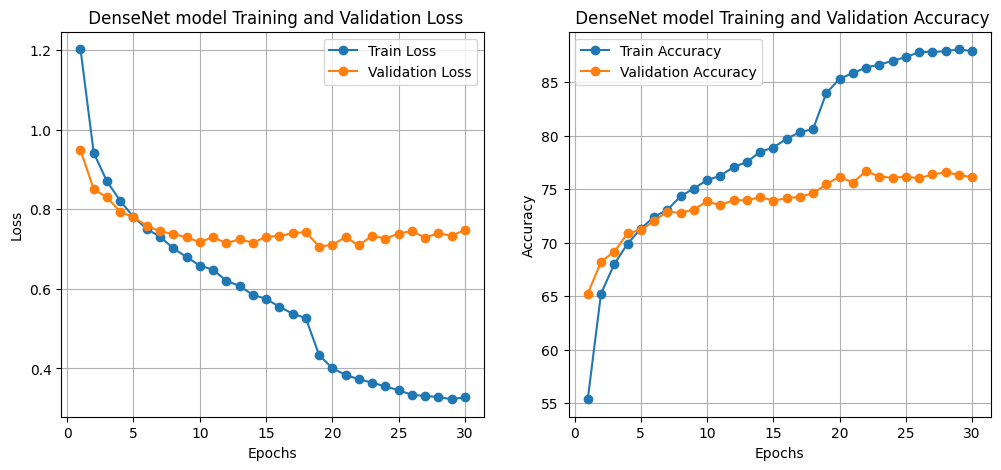

In [11]:
def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(' DenseNet model Training and Validation Loss')
    plt.legend()
    plt.grid()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(' DenseNet model Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    
    plt.show()

# Misol uchun tarix
history = {
    'train_loss': [1.2021, 0.9415, 0.8700, 0.8209, 0.7808, 0.7507, 0.7311, 0.7020, 0.6802, 0.6584, 0.6482, 0.6205, 0.6073, 0.5849, 0.5750, 0.5553, 0.5377, 0.5268, 0.4342, 0.4004, 0.3840, 0.3729, 0.3646, 0.3548, 0.3455, 0.3337, 0.3311, 0.3282, 0.3227, 0.3275],
    'val_loss': [0.9484, 0.8502, 0.8301, 0.7937, 0.7798, 0.7588, 0.7443, 0.7383, 0.7291, 0.7177, 0.7302, 0.7143, 0.7251, 0.7158, 0.7307, 0.7328, 0.7397, 0.7429, 0.7063, 0.7105, 0.7300, 0.7092, 0.7333, 0.7262, 0.7388, 0.7453, 0.7289, 0.7398, 0.7334, 0.7477],
    'train_acc': [55.37, 65.25, 67.99, 69.90, 71.30, 72.42, 73.05, 74.34, 75.06, 75.84, 76.26, 77.06, 77.54, 78.48, 78.89, 79.71, 80.33, 80.61, 83.97, 85.32, 85.84, 86.37, 86.65, 86.99, 87.35, 87.80, 87.85, 87.88, 88.08, 87.89],
    'val_acc': [65.23, 68.23, 69.15, 70.87, 71.19, 72.01, 72.91, 72.78, 73.10, 73.86, 73.49, 73.98, 73.96, 74.26, 73.94, 74.14, 74.30, 74.60, 75.47, 76.16, 75.62, 76.69, 76.17, 76.07, 76.17, 76.01, 76.39, 76.56, 76.35, 76.10]
}

plot_training(history)

# Visualization ResNet50

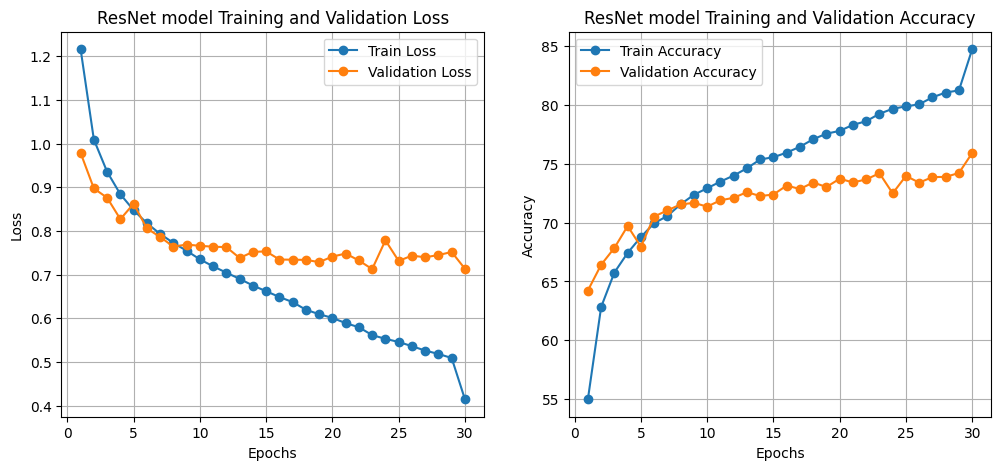

In [12]:
def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('ResNet model Training and Validation Loss')
    plt.legend()
    plt.grid()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('ResNet model Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    
    plt.show()

# Misol uchun tarix
history = {
    'train_loss': [1.2162, 1.0093, 0.9356, 0.8840, 0.8477, 0.8178, 0.7933, 0.7726, 0.7547, 0.7350, 0.7190, 0.7045, 0.6903, 0.6751, 0.6620, 0.6488, 0.6371, 0.6196, 0.6094, 0.6009, 0.5890, 0.5795, 0.5615, 0.5530, 0.5458, 0.5362, 0.5261, 0.5184, 0.5091, 0.4147],
    'val_loss': [0.9787, 0.8974, 0.8761, 0.8270, 0.8624, 0.8058, 0.7863, 0.7641, 0.7689, 0.7660, 0.7640, 0.7630, 0.7381, 0.7521, 0.7532, 0.7346, 0.7342, 0.7338, 0.7287, 0.7413, 0.7483, 0.7324, 0.7126, 0.7785, 0.7314, 0.7435, 0.7398, 0.7448, 0.7519, 0.7135],
    'train_acc': [54.99, 62.83, 65.76, 67.43, 68.78, 69.95, 70.57, 71.56, 72.37, 72.92, 73.49, 74.00, 74.62, 75.37, 75.56, 75.95, 76.45, 77.09, 77.56, 77.80, 78.31, 78.62, 79.25, 79.68, 79.88, 80.06, 80.65, 81.06, 81.24, 84.74],
    'val_acc': [64.23, 66.42, 67.85, 69.71, 67.96, 70.52, 71.04, 71.55, 71.68, 71.36, 71.90, 72.11, 72.59, 72.26, 72.39, 73.15, 72.86, 73.41, 73.03, 73.73, 73.42, 73.67, 74.20, 72.49, 73.97, 73.40, 73.87, 73.89, 74.22, 75.92]
}

plot_training(history)